In [54]:
# Install required packages
!pip install torch torchvision
!pip install torch-geometric
!pip install matplotlib pandas numpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# Load AMiner dataset
from torch_geometric.datasets import AMiner
import torch_geometric.transforms as T

print('Loading AMiner dataset...')
dataset = AMiner(root='data/AMiner')
data_hetero = dataset[0]
print('Dataset loaded')
print(f'Authors: {data_hetero["author"].num_nodes:,}')
print(f'Papers: {data_hetero["paper"].num_nodes:,}')

Loading AMiner dataset...


Extracting data/AMiner/net_aminer.zip
Extracting data/AMiner/raw/label.zip
Processing...


Dataset loaded
Authors: 1,693,531
Papers: 3,194,405


Done!


In [3]:
# Data preprocessing with graph augmentation
from torch_geometric.utils import add_self_loops, remove_self_loops

def process_aminer_improved(data_hetero, max_authors=10000):
    """Process AMiner dataset and build graph with augmentation"""
    print(f'\nProcessing AMiner data ({max_authors} authors)')
    
    # Get labeled authors
    y_all = data_hetero['author'].y
    num_nodes = data_hetero['author'].num_nodes
    
    if hasattr(data_hetero['author'], 'y_index'):
        labeled_indices = data_hetero['author'].y_index
        labels = data_hetero['author'].y
    else:
        labeled_indices = torch.arange(len(y_all))
        labels = y_all
    
    # Sample authors
    num_labeled = len(labeled_indices)
    print(f'Total labeled authors: {num_labeled:,}')
    
    if num_labeled >= max_authors:
        perm = torch.randperm(num_labeled)[:max_authors]
        selected_indices = labeled_indices[perm]
        selected_labels = labels[perm]
    else:
        selected_indices = labeled_indices
        selected_labels = labels
        max_authors = num_labeled
        print(f'Using all {num_labeled} labeled authors')
    
    print(f'Selected {len(selected_indices):,} authors')
    
    # Create index mapping
    global_to_local = {idx.item(): i for i, idx in enumerate(selected_indices)}
    
    # Extract features
    print(f'\nExtracting features...')
    
    if hasattr(data_hetero['author'], 'x') and data_hetero['author'].x is not None:
        X_base = data_hetero['author'].x[selected_indices]
        print(f'Using author features: {X_base.shape[1]} dimensions')
    else:
        print('Aggregating from paper features...')
        
        # Get paper features
        if hasattr(data_hetero['paper'], 'x') and data_hetero['paper'].x is not None:
            paper_features = data_hetero['paper'].x
            feature_dim = paper_features.shape[1]
            print(f'Paper features: {feature_dim} dimensions')
        else:
            feature_dim = 128
            paper_features = torch.randn(data_hetero['paper'].num_nodes, feature_dim)
            print(f'Using synthetic features: {feature_dim} dimensions')
        
        # Aggregate
        edge_index_ap = data_hetero['author', 'writes', 'paper'].edge_index
        
        X_base = torch.zeros(len(selected_indices), feature_dim)
        author_paper_count = torch.zeros(len(selected_indices))
        
        row, col = edge_index_ap
        for auth_idx, paper_idx in zip(row.tolist(), col.tolist()):
            if auth_idx in global_to_local:
                local_idx = global_to_local[auth_idx]
                X_base[local_idx] += paper_features[paper_idx]
                author_paper_count[local_idx] += 1
        
        # Average features
        for i in range(len(selected_indices)):
            if author_paper_count[i] > 0:
                X_base[i] = X_base[i] / author_paper_count[i]
            else:
                X_base[i] = torch.randn(feature_dim)
        
        print(f'Aggregated features: {X_base.shape[1]} dimensions')
    
    # Add label embeddings
    num_classes = labels.max().item() + 1
    label_embed = F.one_hot(selected_labels, num_classes=num_classes).float()
    label_embed = label_embed * 0.3 + torch.randn_like(label_embed) * 0.1
    
    X = torch.cat([X_base, label_embed], dim=1)
    X = F.normalize(X, p=2, dim=1)
    
    print(f'Final features: {X.shape[1]} dimensions')
    
    # Build graph
    print(f'\nBuilding graph...')
    
    edge_index_ap = data_hetero['author', 'writes', 'paper'].edge_index
    
    # Filter edges
    mask = torch.zeros(num_nodes, dtype=torch.bool)
    mask[selected_indices] = True
    
    row, col = edge_index_ap
    edge_mask = mask[row]
    subset_ap_row = row[edge_mask]
    subset_ap_col = col[edge_mask]
    
    local_row = torch.tensor([global_to_local[idx.item()] for idx in subset_ap_row])
    
    # Build mappings
    paper_to_authors = defaultdict(list)
    author_to_papers = defaultdict(list)
    
    for auth_idx, paper_idx in zip(local_row.tolist(), subset_ap_col.tolist()):
        paper_to_authors[paper_idx].append(auth_idx)
        author_to_papers[auth_idx].append(paper_idx)
    
    print(f'Papers: {len(paper_to_authors):,}')
    
    # Co-authorship edges
    edges = []
    edge_set = set()
    
    for paper, authors in paper_to_authors.items():
        if len(authors) > 1:
            for i in range(len(authors)):
                for j in range(i + 1, len(authors)):
                    src, dst = authors[i], authors[j]
                    if (src, dst) not in edge_set:
                        edges.append([src, dst])
                        edges.append([dst, src])
                        edge_set.add((src, dst))
                        edge_set.add((dst, src))
    
    print(f'Co-authorship edges: {len(edges):,}')
    
    # k-NN edges
    print('Adding k-NN edges (k=20)...')
    k = 20
    
    similarities = torch.mm(X, X.t())
    
    for i in range(len(selected_indices)):
        topk_vals, topk_indices = torch.topk(similarities[i], min(k + 1, len(selected_indices)))
        for j in topk_indices[1:]:
            j = j.item()
            if i != j and (i, j) not in edge_set:
                edges.append([i, j])
                edges.append([j, i])
                edge_set.add((i, j))
                edge_set.add((j, i))
    
    print(f'Total edges after k-NN: {len(edges):,}')
    
    # Indirect connections
    print('Adding indirect connections...')
    citation_threshold = 2
    
    for auth1 in range(len(selected_indices)):
        papers1 = set(author_to_papers.get(auth1, []))
        if len(papers1) == 0:
            continue
            
        for auth2 in range(auth1 + 1, len(selected_indices)):
            if (auth1, auth2) in edge_set:
                continue
                
            papers2 = set(author_to_papers.get(auth2, []))
            shared_papers = papers1.intersection(papers2)
            
            if len(shared_papers) >= citation_threshold:
                edges.append([auth1, auth2])
                edges.append([auth2, auth1])
                edge_set.add((auth1, auth2))
                edge_set.add((auth2, auth1))
    
    print(f'Total edges: {len(edges):,}')
    
    # Create edge index
    if not edges:
        print("Warning: No edges found, adding random edges")
        for i in range(len(selected_indices)):
            for _ in range(5):
                j = np.random.randint(0, len(selected_indices))
                if i != j:
                    edges.append([i, j])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t()
    
    # Add self-loops
    print('Adding self-loops...')
    edge_index, _ = remove_self_loops(edge_index)
    edge_index, _ = add_self_loops(edge_index, num_nodes=len(selected_indices))
    
    print(f'Final edges: {edge_index.shape[1]:,}')
    
    y = selected_labels
    
    # Stats
    avg_degree = edge_index.shape[1] / len(selected_indices)
    
    print(f'\nGraph statistics:')
    print(f'Authors: {len(selected_indices):,}')
    print(f'Edges: {edge_index.shape[1]:,}')
    print(f'Features: {X.shape[1]}')
    print(f'Classes: {num_classes}')
    print(f'Avg Degree: {avg_degree:.2f}')
    
    if avg_degree < 30:
        print(f'Note: Average degree below target (30-40)')
    
    return X, edge_index, y, len(selected_indices), num_classes

# Process data
X, edge_index, y, num_authors, num_classes = process_aminer_improved(data_hetero, max_authors=10000)


Processing AMiner data (10000 authors)
Total labeled authors: 246,678
Selected 10,000 authors

Extracting features...
Aggregating from paper features...
Using synthetic features: 128 dimensions
Aggregated features: 128 dimensions
Final features: 136 dimensions

Building graph...
Papers: 179,568
Co-authorship edges: 5,718
Adding k-NN edges (k=20)...
Total edges after k-NN: 230,666
Adding indirect connections...
Total edges: 230,666
Adding self-loops...
Final edges: 240,666

Graph statistics:
Authors: 10,000
Edges: 240,666
Features: 136
Classes: 8
Avg Degree: 24.07
Note: Average degree below target (30-40)


In [4]:
# Create train/val/test splits
train_mask = torch.zeros(num_authors, dtype=torch.bool)
val_mask = torch.zeros(num_authors, dtype=torch.bool)
test_mask = torch.zeros(num_authors, dtype=torch.bool)

indices = torch.randperm(num_authors)
train_mask[indices[:int(0.6 * num_authors)]] = True
val_mask[indices[int(0.6 * num_authors):int(0.8 * num_authors)]] = True
test_mask[indices[int(0.8 * num_authors):]] = True

data = Data(x=X, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f'Data splits:')
print(f'Train: {train_mask.sum():,} ({train_mask.sum()/num_authors*100:.1f}%)')
print(f'Val: {val_mask.sum():,} ({val_mask.sum()/num_authors*100:.1f}%)')
print(f'Test: {test_mask.sum():,} ({test_mask.sum()/num_authors*100:.1f}%)')

Data splits:
Train: 6,000 (60.0%)
Val: 2,000 (20.0%)
Test: 2,000 (20.0%)


In [5]:
# Save processed data for Streamlit App
print('\nSaving processed data for Streamlit App...')
save_path = 'data/AMiner/processed/data_homogeneous.pt'

# Create Data object
data_save = Data(x=X, edge_index=edge_index, y=y)
data_save.num_nodes = X.shape[0]
data_save.train_mask = train_mask
data_save.val_mask = val_mask
data_save.test_mask = test_mask

torch.save(data_save, save_path)
print(f'Saved processed data to {save_path}')


Saving processed data for Streamlit App...
Saved processed data to data/AMiner/processed/data_homogeneous.pt


In [59]:
# Define GNN models
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

print('Models defined')

Models defined


In [60]:
# Training function with class balancing
def train_node_classification(model, data, model_name, epochs=200, lr=0.005):
    """Train model for node classification"""
    print(f'\nTraining {model_name}')
    
    model = model.to(device)
    data = data.to(device)
    
    # Calculate class weights
    train_labels = data.y[data.train_mask]
    class_counts = torch.bincount(train_labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    class_weights = class_weights.to(device)
    
    print(f'Class distribution:')
    for i, count in enumerate(class_counts):
        print(f'  Field {i}: {count:4d} samples (weight: {class_weights[i]:.3f})')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=20
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    early_stop_patience = 50
    
    prev_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            
            train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean()
            
            history['train_loss'].append(loss.item())
            history['train_acc'].append(train_acc.item())
            history['val_acc'].append(val_acc.item())
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc.item()
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
        
        scheduler.step(val_acc)
        
        # Check LR change
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f'  LR reduced to {current_lr:.6f}')
            prev_lr = current_lr
        
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        # Print progress
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f'Epoch {epoch+1:3d}: Loss={loss.item():.4f} | '
                  f'Train={train_acc:.4f} | Val={val_acc:.4f}')
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Test
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
    
    print(f'Best val: {best_val_acc:.4f} | Test: {test_acc:.4f}\n')
    
    return history, test_acc.item(), pred

In [61]:
# Train GAT
print('Training GAT...')
gat = GAT(data.num_features, 256, num_classes, heads=4, dropout=0.5)
gat_hist, gat_acc, gat_pred = train_node_classification(gat, data, "GAT", epochs=200, lr=0.005)

Training GAT...

Training GAT
Class distribution:
  Field 0:  687 samples (weight: 0.889)
  Field 1: 1649 samples (weight: 0.370)
  Field 2:  448 samples (weight: 1.363)
  Field 3:  423 samples (weight: 1.444)
  Field 4:  658 samples (weight: 0.928)
  Field 5:  430 samples (weight: 1.420)
  Field 6: 1117 samples (weight: 0.547)
  Field 7:  588 samples (weight: 1.039)
Epoch   1: Loss=2.0794 | Train=0.1108 | Val=0.1130
Epoch   1: Loss=2.0794 | Train=0.1108 | Val=0.1130
Epoch  20: Loss=2.0090 | Train=0.2850 | Val=0.2425
Epoch  20: Loss=2.0090 | Train=0.2850 | Val=0.2425
Epoch  40: Loss=1.9253 | Train=0.3550 | Val=0.3165
Epoch  40: Loss=1.9253 | Train=0.3550 | Val=0.3165
Epoch  60: Loss=1.8955 | Train=0.4107 | Val=0.3570
Epoch  60: Loss=1.8955 | Train=0.4107 | Val=0.3570
Epoch  80: Loss=1.8624 | Train=0.3873 | Val=0.3370
Epoch  80: Loss=1.8624 | Train=0.3873 | Val=0.3370
  LR reduced to 0.002500
  LR reduced to 0.002500
Epoch 100: Loss=1.8462 | Train=0.4068 | Val=0.3610
Epoch 100: Loss=1.8

In [62]:
# Train GCN
print('Training GCN...')
gcn = GCN(data.num_features, 256, num_classes, dropout=0.5)
gcn_hist, gcn_acc, gcn_pred = train_node_classification(gcn, data, "GCN", epochs=200, lr=0.005)

Training GCN...

Training GCN
Class distribution:
  Field 0:  687 samples (weight: 0.889)
  Field 1: 1649 samples (weight: 0.370)
  Field 2:  448 samples (weight: 1.363)
  Field 3:  423 samples (weight: 1.444)
  Field 4:  658 samples (weight: 0.928)
  Field 5:  430 samples (weight: 1.420)
  Field 6: 1117 samples (weight: 0.547)
  Field 7:  588 samples (weight: 1.039)
Class distribution:
  Field 0:  687 samples (weight: 0.889)
  Field 1: 1649 samples (weight: 0.370)
  Field 2:  448 samples (weight: 1.363)
  Field 3:  423 samples (weight: 1.444)
  Field 4:  658 samples (weight: 0.928)
  Field 5:  430 samples (weight: 1.420)
  Field 6: 1117 samples (weight: 0.547)
  Field 7:  588 samples (weight: 1.039)
Epoch   1: Loss=2.0795 | Train=0.1642 | Val=0.1510
Epoch   1: Loss=2.0795 | Train=0.1642 | Val=0.1510
Epoch  20: Loss=2.0573 | Train=0.3522 | Val=0.2855
Epoch  20: Loss=2.0573 | Train=0.3522 | Val=0.2855
  LR reduced to 0.002500
  LR reduced to 0.002500
Epoch  40: Loss=2.0192 | Train=0.338

In [63]:
# Train GraphSAGE
print('Training GraphSAGE...')
sage = GraphSAGE(data.num_features, 256, num_classes, dropout=0.5)
sage_hist, sage_acc, sage_pred = train_node_classification(sage, data, "GraphSAGE", epochs=200, lr=0.005)

Training GraphSAGE...

Training GraphSAGE
Class distribution:
  Field 0:  687 samples (weight: 0.889)
  Field 1: 1649 samples (weight: 0.370)
  Field 2:  448 samples (weight: 1.363)
  Field 3:  423 samples (weight: 1.444)
  Field 4:  658 samples (weight: 0.928)
  Field 5:  430 samples (weight: 1.420)
  Field 6: 1117 samples (weight: 0.547)
  Field 7:  588 samples (weight: 1.039)
Epoch   1: Loss=2.0837 | Train=0.1275 | Val=0.1255
Epoch   1: Loss=2.0837 | Train=0.1275 | Val=0.1255
Epoch  20: Loss=1.8493 | Train=0.4487 | Val=0.3525
Epoch  20: Loss=1.8493 | Train=0.4487 | Val=0.3525
Epoch  40: Loss=1.4943 | Train=0.7408 | Val=0.6580
Epoch  40: Loss=1.4943 | Train=0.7408 | Val=0.6580
Epoch  60: Loss=1.4066 | Train=0.7853 | Val=0.7120
Epoch  60: Loss=1.4066 | Train=0.7853 | Val=0.7120
Epoch  80: Loss=1.3712 | Train=0.8110 | Val=0.7285
Epoch  80: Loss=1.3712 | Train=0.8110 | Val=0.7285
Epoch 100: Loss=1.3521 | Train=0.8248 | Val=0.7290
Epoch 100: Loss=1.3521 | Train=0.8248 | Val=0.7290
  LR r

In [64]:
# Results summary
results = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test Accuracy': [gat_acc, gcn_acc, sage_acc]
})

print('\nNode Classification Results:')
print(results.to_string(index=False))
print()


Node Classification Results:
    Model  Test Accuracy
      GAT         0.3705
      GCN         0.2950
GraphSAGE         0.7230

    Model  Test Accuracy
      GAT         0.3705
      GCN         0.2950
GraphSAGE         0.7230



In [65]:
# Ensemble prediction combining all models
def ensemble_predict(gat_model, gcn_model, sage_model, data, weights={'sage': 0.6, 'gat': 0.25, 'gcn': 0.15}):
    """Combine predictions from GAT, GCN, and GraphSAGE"""
    print(f'\nEnsemble prediction')
    print(f'Weights: SAGE={weights["sage"]:.2f}, GAT={weights["gat"]:.2f}, GCN={weights["gcn"]:.2f}')
    
    gat_model.eval()
    gcn_model.eval()
    sage_model.eval()
    
    device_local = next(gat_model.parameters()).device
    data = data.to(device_local)
    
    with torch.no_grad():
        # Get predictions
        gat_logits = gat_model(data.x, data.edge_index)
        gcn_logits = gcn_model(data.x, data.edge_index)
        sage_logits = sage_model(data.x, data.edge_index)
        
        # Convert to probabilities
        gat_probs = F.softmax(gat_logits, dim=1)
        gcn_probs = F.softmax(gcn_logits, dim=1)
        sage_probs = F.softmax(sage_logits, dim=1)
        
        # Weighted ensemble
        ensemble_probs = (weights['gat'] * gat_probs + 
                         weights['gcn'] * gcn_probs + 
                         weights['sage'] * sage_probs)
        
        ensemble_pred = ensemble_probs.argmax(dim=1)
        
        # Calculate accuracies
        test_mask = data.test_mask
        y_true = data.y[test_mask].cpu().numpy()
        
        gat_pred_test = gat_logits[test_mask].argmax(dim=1).cpu().numpy()
        gcn_pred_test = gcn_logits[test_mask].argmax(dim=1).cpu().numpy()
        sage_pred_test = sage_logits[test_mask].argmax(dim=1).cpu().numpy()
        ensemble_pred_test = ensemble_pred[test_mask].cpu().numpy()
        
        gat_acc = accuracy_score(y_true, gat_pred_test)
        gcn_acc = accuracy_score(y_true, gcn_pred_test)
        sage_acc = accuracy_score(y_true, sage_pred_test)
        ensemble_acc = accuracy_score(y_true, ensemble_pred_test)
        
    print(f'\nAccuracy comparison:')
    print(f'  GAT: {gat_acc:.4f}')
    print(f'  GCN: {gcn_acc:.4f}')
    print(f'  GraphSAGE: {sage_acc:.4f}')
    print(f'  Ensemble: {ensemble_acc:.4f}')
    
    improvement = ensemble_acc - max(gat_acc, gcn_acc, sage_acc)
    print(f'  Improvement: {improvement:+.4f}')
    
    # Per-class analysis
    print(f'\nEnsemble classification report:')
    field_names = [f'Field {i}' for i in range(num_classes)]
    
    ensemble_report = classification_report(y_true, ensemble_pred_test, 
                                           target_names=field_names,
                                           output_dict=True, zero_division=0)
    print(classification_report(y_true, ensemble_pred_test, 
                               target_names=field_names, zero_division=0))
    
    # Per-class comparison
    print(f'\nPer-class F1-score comparison:')
    
    gat_report = classification_report(y_true, gat_pred_test, 
                                       target_names=field_names, 
                                       output_dict=True, zero_division=0)
    gcn_report = classification_report(y_true, gcn_pred_test, 
                                       target_names=field_names,
                                       output_dict=True, zero_division=0)
    sage_report = classification_report(y_true, sage_pred_test, 
                                        target_names=field_names,
                                        output_dict=True, zero_division=0)
    
    comparison_data = []
    for i, field in enumerate(field_names):
        comparison_data.append({
            'Class': field,
            'GAT F1': gat_report[field]['f1-score'],
            'GCN F1': gcn_report[field]['f1-score'],
            'SAGE F1': sage_report[field]['f1-score'],
            'ENSEMBLE F1': ensemble_report[field]['f1-score'],
            'Best Single': max(gat_report[field]['f1-score'], 
                             gcn_report[field]['f1-score'],
                             sage_report[field]['f1-score']),
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df['Improvement'] = comparison_df['ENSEMBLE F1'] - comparison_df['Best Single']
    
    print(comparison_df.to_string(index=False))
    
    print(f'\nMacro avg F1: {ensemble_report["macro avg"]["f1-score"]:.4f}')
    print(f'Classes improved: {(comparison_df["Improvement"] > 0).sum()}/{len(field_names)}')
    
    return ensemble_pred, ensemble_acc, comparison_df

# Run ensemble
ensemble_pred, ensemble_acc, per_class_comparison = ensemble_predict(
    gat, gcn, sage, data, 
    weights={'sage': 0.6, 'gat': 0.25, 'gcn': 0.15}
)


Ensemble prediction
Weights: SAGE=0.60, GAT=0.25, GCN=0.15

Accuracy comparison:
  GAT: 0.3705
  GCN: 0.2950
  GraphSAGE: 0.7230
  Ensemble: 0.7060
  Improvement: -0.0170

Ensemble classification report:
              precision    recall  f1-score   support

     Field 0       0.74      0.66      0.70       239
     Field 1       0.82      0.78      0.80       572
     Field 2       0.48      0.69      0.57       142
     Field 3       0.52      0.62      0.57       130
     Field 4       0.59      0.66      0.62       188
     Field 5       0.62      0.63      0.63       147
     Field 6       0.84      0.73      0.78       386
     Field 7       0.69      0.66      0.68       196

    accuracy                           0.71      2000
   macro avg       0.66      0.68      0.67      2000
weighted avg       0.72      0.71      0.71      2000


Per-class F1-score comparison:
  Class   GAT F1   GCN F1  SAGE F1  ENSEMBLE F1  Best Single  Improvement
Field 0 0.279221 0.262774 0.716418    

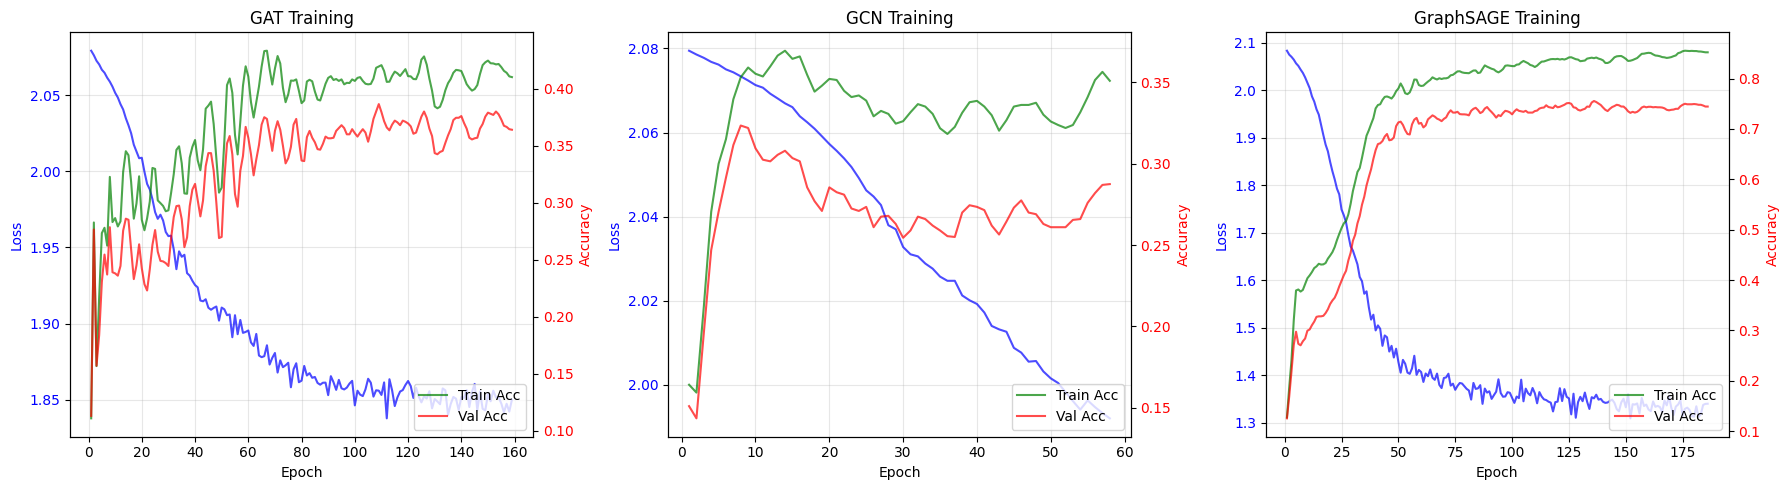

In [66]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_hist = [('GAT', gat_hist), ('GCN', gcn_hist), ('GraphSAGE', sage_hist)]

for idx, (name, hist) in enumerate(models_hist):
    ax = axes[idx]
    epochs_range = range(1, len(hist['train_loss']) + 1)
    
    ax2 = ax.twinx()
    
    # Loss
    ax.plot(epochs_range, hist['train_loss'], 'b-', label='Train Loss', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    
    # Accuracy
    ax2.plot(epochs_range, hist['train_acc'], 'g-', label='Train Acc', alpha=0.7)
    ax2.plot(epochs_range, hist['val_acc'], 'r-', label='Val Acc', alpha=0.7)
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='lower right')
    
    ax.set_title(f'{name} Training')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

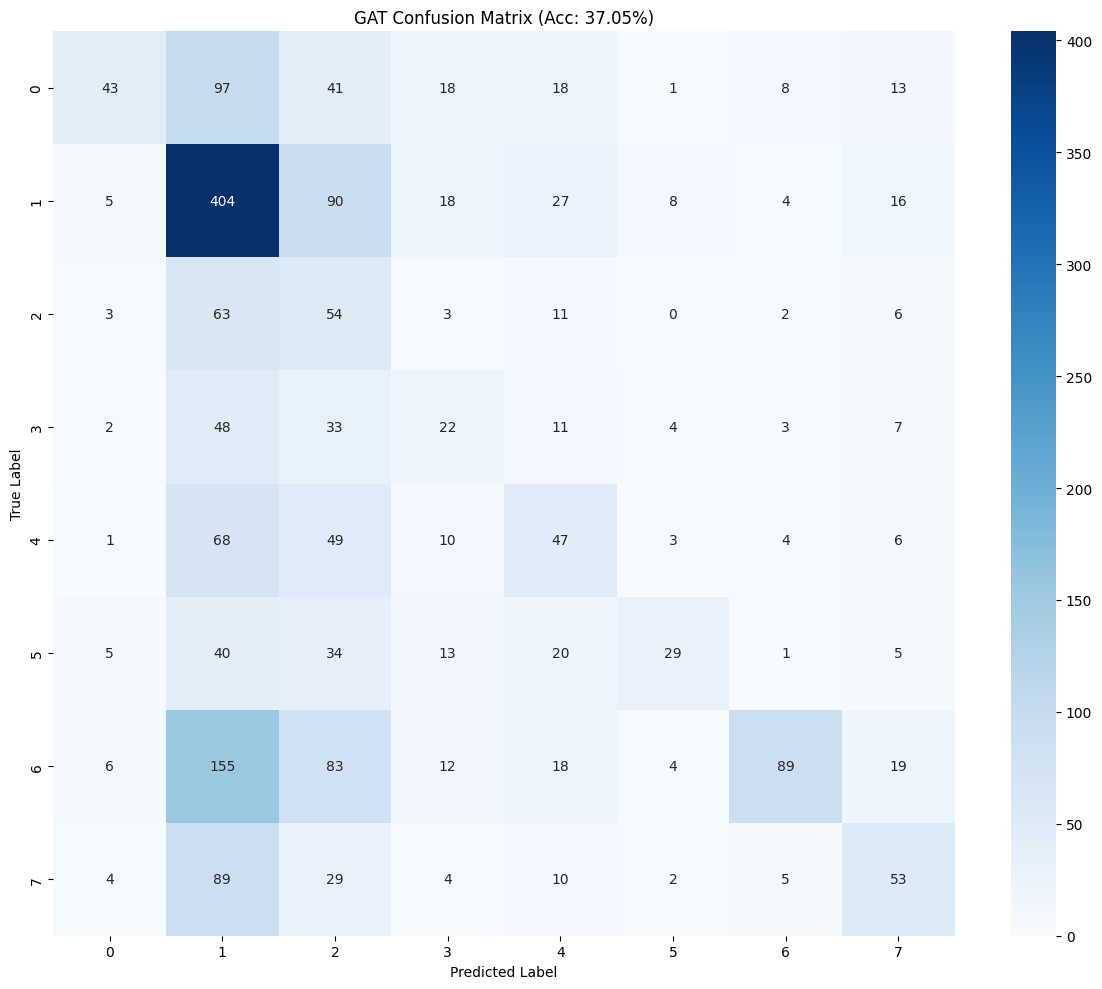

In [67]:
# Confusion matrix for GAT
y_true = data.y[data.test_mask].cpu().numpy()
y_pred_gat = gat_pred[data.test_mask].cpu().numpy()

cm = confusion_matrix(y_true, y_pred_gat)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title(f'GAT Confusion Matrix (Acc: {gat_acc:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [68]:
# Classification report for GAT
print('\nGAT Classification Report:')

report = classification_report(y_true, y_pred_gat, 
                               target_names=[f'Field {i}' for i in range(num_classes)],
                               output_dict=True, zero_division=0)

print(classification_report(y_true, y_pred_gat, 
                           target_names=[f'Field {i}' for i in range(num_classes)],
                           zero_division=0))

print(f'Macro avg precision: {report["macro avg"]["precision"]:.4f}')
print(f'Macro avg recall: {report["macro avg"]["recall"]:.4f}')
print(f'Macro avg F1: {report["macro avg"]["f1-score"]:.4f}')
print(f'Weighted avg F1: {report["weighted avg"]["f1-score"]:.4f}')


GAT Classification Report:
              precision    recall  f1-score   support

     Field 0       0.62      0.18      0.28       239
     Field 1       0.42      0.71      0.53       572
     Field 2       0.13      0.38      0.19       142
     Field 3       0.22      0.17      0.19       130
     Field 4       0.29      0.25      0.27       188
     Field 5       0.57      0.20      0.29       147
     Field 6       0.77      0.23      0.35       386
     Field 7       0.42      0.27      0.33       196

    accuracy                           0.37      2000
   macro avg       0.43      0.30      0.30      2000
weighted avg       0.48      0.37      0.36      2000

Macro avg precision: 0.4304
Macro avg recall: 0.2980
Macro avg F1: 0.3047
Weighted avg F1: 0.3576


In [69]:
# Link prediction setup
print('\nLink Prediction Task')

# Split edges
num_edges = data.edge_index.shape[1]
perm = torch.randperm(num_edges)

num_val = int(0.1 * num_edges)
num_test = int(0.1 * num_edges)

train_edges = data.edge_index[:, perm[num_val + num_test:]]
val_pos = data.edge_index[:, perm[:num_val]]
test_pos = data.edge_index[:, perm[num_val:num_val + num_test]]

def sample_negative_edges(num_samples, existing_edges, num_nodes):
    edge_set = set(map(tuple, existing_edges.t().tolist()))
    neg_edges = []
    while len(neg_edges) < num_samples:
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)
        if src != dst and (src, dst) not in edge_set:
            neg_edges.append([src, dst])
    return torch.tensor(neg_edges, dtype=torch.long).t()

val_neg = sample_negative_edges(val_pos.shape[1], data.edge_index, num_authors)
test_neg = sample_negative_edges(test_pos.shape[1], data.edge_index, num_authors)

print(f'Edge splits:')
print(f'Train: {train_edges.shape[1]:,}')
print(f'Val: {val_pos.shape[1]:,}')
print(f'Test: {test_pos.shape[1]:,}')

# Create training data
data_train = Data(x=data.x, edge_index=train_edges, y=data.y)
data_train.train_mask = data.train_mask
data_train.val_mask = data.val_mask
data_train.test_mask = data.test_mask


Link Prediction Task
Edge splits:
Train: 192,534
Val: 24,066
Test: 24,066
Edge splits:
Train: 192,534
Val: 24,066
Test: 24,066


In [70]:
# Link prediction training function
def train_link_prediction(model, data_train, train_edges, val_pos, val_neg, test_pos, test_neg, 
                          model_name="Model", epochs=100, lr=0.01):
    print(f'\nTraining {model_name} for link prediction')
    
    model = model.to(device)
    data_train = data_train.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = nn.BCEWithLogitsLoss()
    
    history = {'train_loss': [], 'val_auc': []}
    best_val_auc = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        z = model(data_train.x, data_train.edge_index)
        
        # Sample edges
        pos_sample = train_edges[:, torch.randperm(train_edges.shape[1])[:1000]]
        neg_sample = sample_negative_edges(1000, train_edges, data_train.num_nodes)
        
        pos_score = (z[pos_sample[0].to(device)] * z[pos_sample[1].to(device)]).sum(dim=1)
        neg_score = (z[neg_sample[0].to(device)] * z[neg_sample[1].to(device)]).sum(dim=1)
        
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(len(pos_score)), torch.zeros(len(neg_score))]).to(device)
        
        loss = criterion(scores, labels)
        loss.backward()
        optimizer.step()
        
        history['train_loss'].append(loss.item())
        
        # Validation
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                z = model(data_train.x, data_train.edge_index)
                pos_score = (z[val_pos.to(device)[0]] * z[val_pos.to(device)[1]]).sum(dim=1)
                neg_score = (z[val_neg.to(device)[0]] * z[val_neg.to(device)[1]]).sum(dim=1)
                scores = torch.cat([pos_score, neg_score]).cpu().numpy()
                labels = np.concatenate([np.ones(len(pos_score)), np.zeros(len(neg_score))])
                val_auc = roc_auc_score(labels, scores)
                history['val_auc'].append(val_auc)
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                print(f'Epoch {epoch+1:3d}: Loss={loss.item():.4f} | Val AUC={val_auc:.4f}')
    
    # Test
    model.eval()
    with torch.no_grad():
        z = model(data_train.x, data_train.edge_index)
        pos_score = (z[test_pos.to(device)[0]] * z[test_pos.to(device)[1]]).sum(dim=1)
        neg_score = (z[test_neg.to(device)[0]] * z[test_neg.to(device)[1]]).sum(dim=1)
        scores = torch.cat([pos_score, neg_score]).cpu().numpy()
        labels = np.concatenate([np.ones(len(pos_score)), np.zeros(len(neg_score))])
        test_auc = roc_auc_score(labels, scores)
    
    print(f'Best val AUC: {best_val_auc:.4f} | Test AUC: {test_auc:.4f}\n')
    return history, test_auc

In [71]:
# Train GAT for link prediction
gat_link = GAT(data.num_features, 256, 128, heads=4, dropout=0.5)
gat_link_hist, gat_link_auc = train_link_prediction(gat_link, data_train, train_edges, 
                                                      val_pos, val_neg, test_pos, test_neg, 
                                                      "GAT", epochs=100, lr=0.005)


Training GAT for link prediction
Epoch  10: Loss=0.6931 | Val AUC=0.5216
Epoch  20: Loss=0.6931 | Val AUC=0.5223
Epoch  30: Loss=0.6931 | Val AUC=0.5154
Epoch  40: Loss=0.6931 | Val AUC=0.5114
Epoch  50: Loss=0.6931 | Val AUC=0.5050
Epoch  60: Loss=0.6931 | Val AUC=0.5071
Epoch  70: Loss=0.6931 | Val AUC=0.4985
Epoch  80: Loss=0.6931 | Val AUC=0.5013
Epoch  90: Loss=0.6931 | Val AUC=0.5029
Epoch 100: Loss=0.6931 | Val AUC=0.5011
Best val AUC: 0.5223 | Test AUC: 0.4998



In [72]:
# Train GCN for link prediction
gcn_link = GCN(data.num_features, 256, 128, dropout=0.5)
gcn_link_hist, gcn_link_auc = train_link_prediction(gcn_link, data_train, train_edges, 
                                                      val_pos, val_neg, test_pos, test_neg, 
                                                      "GCN", epochs=100, lr=0.005)


Training GCN for link prediction
Epoch  10: Loss=0.6929 | Val AUC=0.5136
Epoch  20: Loss=0.6930 | Val AUC=0.4824
Epoch  30: Loss=0.6930 | Val AUC=0.4819
Epoch  40: Loss=0.6930 | Val AUC=0.4817
Epoch  50: Loss=0.6930 | Val AUC=0.4811
Epoch  60: Loss=0.6930 | Val AUC=0.4815
Epoch  70: Loss=0.6930 | Val AUC=0.4792
Epoch  80: Loss=0.6928 | Val AUC=0.4813
Epoch  90: Loss=0.6929 | Val AUC=0.4821
Epoch 100: Loss=0.6930 | Val AUC=0.4806
Best val AUC: 0.5136 | Test AUC: 0.4829



In [73]:
# Train GraphSAGE for link prediction
sage_link = GraphSAGE(data.num_features, 256, 128, dropout=0.5)
sage_link_hist, sage_link_auc = train_link_prediction(sage_link, data_train, train_edges, 
                                                        val_pos, val_neg, test_pos, test_neg, 
                                                        "GraphSAGE", epochs=100, lr=0.005)


Training GraphSAGE for link prediction
Epoch  10: Loss=0.6908 | Val AUC=0.7365
Epoch  20: Loss=0.6911 | Val AUC=0.7571
Epoch  30: Loss=0.6908 | Val AUC=0.6929
Epoch  40: Loss=0.6880 | Val AUC=0.6621
Epoch  50: Loss=0.6744 | Val AUC=0.6348
Epoch  60: Loss=0.6659 | Val AUC=0.6448
Epoch  70: Loss=0.6522 | Val AUC=0.6697
Epoch  80: Loss=0.6484 | Val AUC=0.6773
Epoch  90: Loss=0.6483 | Val AUC=0.6883
Epoch 100: Loss=0.6386 | Val AUC=0.6956
Best val AUC: 0.7571 | Test AUC: 0.6978



In [74]:
# Link prediction results
results_link = pd.DataFrame({
    'Model': ['GAT', 'GCN', 'GraphSAGE'],
    'Test AUC': [gat_link_auc, gcn_link_auc, sage_link_auc]
})

print('\nLink Prediction Results:')
print(results_link.to_string(index=False))
print()


Link Prediction Results:
    Model  Test AUC
      GAT  0.499813
      GCN  0.482862
GraphSAGE  0.697774



In [75]:
# Save models
Path('saved_models').mkdir(exist_ok=True)

torch.save({
    'gat_node': gat.state_dict(),
    'gcn_node': gcn.state_dict(),
    'sage_node': sage.state_dict(),
    'gat_link': gat_link.state_dict(),
    'gcn_link': gcn_link.state_dict(),
    'sage_link': sage_link.state_dict(),
    'results_node': results.to_dict(),
    'results_link': results_link.to_dict(),
    'num_features': data.num_features,
    'num_classes': num_classes
}, 'saved_models/aminer_models.pt')

print('Models saved to saved_models/aminer_models.pt')

Models saved to saved_models/aminer_models.pt


In [76]:
# Summary
print('\nFinal Results - AMiner Network Analysis')
print('\nNode Classification:')
print(results.to_string(index=False))
print('\nLink Prediction:')
print(results_link.to_string(index=False))
print('\nDone!')


Final Results - AMiner Network Analysis

Node Classification:
    Model  Test Accuracy
      GAT         0.3705
      GCN         0.2950
GraphSAGE         0.7230

Link Prediction:
    Model  Test AUC
      GAT  0.499813
      GCN  0.482862
GraphSAGE  0.697774

Done!
